# Reading articles from Wikipedia 
based on the list of names
https://pypi.org/project/wikipedia/

In [1]:
import wikipedia
import pandas as pd
import glob
import csv
import requests

In [2]:
# Search for Wiki articles
print(wikipedia.search('Women in business'))

['Women in business', 'Women in India', 'National Association of Women Business Owners', 'Women in Kazakhstan', "Women's Business Ownership Act", 'Business and Professional Women', 'Women in Business Romania', 'Women in the workforce', 'Karren Brady', 'Woman-owned business']


In [3]:
# Pull contents of a particular page
print(wikipedia.page('Women in business').content)

The phrase women in business refers to women who hold positions, particularly leadership in the fields of commerce, business, and entrepreneurship. It advocates for their increased participation in business. 
Increased participation of women in business can be important for variation in business development, ideas, and business products.   Participation also encourages the development of social networks and supports that have positive repercussions for women and for their social environment. The status of women in business varies significantly around the world. Sometimes a lack of adequate business capital, female education, and training programs in the use of technology  can mean women are more constrained by their social and political environment than men.The number of female entrepreneurs is increasing around in the country, and the Government generally encouraging this. However, a legacy of historical exclusion and discrimination continues to shape the experiences of women in busin

In [212]:
# Pull contents of a particular section of a page
print(wikipedia.page('Women in business').section('Further reading'))

Roger E. Axtell, Tami Briggs, Margaret Corcoran, and Mary Beth Lamb, Do's and Taboos Around the World for Women in Business
Douglas Branson, No Seat at the Table: How Corporate Governance and Law Keep Women Out of the Boardroom
Christ, M. H. 2016. Women in internal audit: Perspectives from around the world. Altamonte Springs, FL: The IIA Research Foundation 2016.
Hine, Darlene Clark. Facts on File Encyclopedia of Black Women in America: Business and Professions (1997)
Krismann, Carol. Encyclopedia of American Women in Business From Colonial Times to the Present (2004)
Lin Coughlin, Ellen Wingard, and Keith Hollihan, Enlightened Power: How Women are Transforming the Practice of Leadership
Harvard Business School Press, editors, Harvard Business Review on Women in Business
National Women's Business Council, African American Women-owned Businesses (2012)
National Women's Business Council, Women in Business: 2007-2010 (2012)
Deborah Rhode, The Difference ""Difference"" Makes: Women and Lea

In [11]:
# Pull names of categories for a page
print(wikipedia.page(title = 'Category:21st-century_American_businesswomen').categories)

['21st-century American businesspeople', '21st-century American women by occupation', '21st-century businesswomen', 'American women in business', 'CatAutoTOC generates standard Category TOC', 'Template Category TOC via CatAutoTOC on category with 601–900 pages', 'Wikipedia non-diffusing subcategories']


## Scrape articles for American Women Chief Executives

In [125]:
# Read the list of Women EE names
df = pd.read_csv('EE_name_country.csv', names = ['name', 'country'])
df.head()

,name,country
0,Sviatlana Tsikhanouskaya,Belarus
1,Olga Abramova (politician),Belarus
2,Alena Anisim,Belarus
3,Natallia Eismant,Belarus
4,Maria Kalesnikava,Belarus


In [127]:
#Save list of countries
country_list = df.country.unique()

# Number of articles in initial list by country
df.groupby('country').count()

,name
country,
Belarus,15
Bulgaria,22
CZ,15
Hungary,57
Moldova,59
Poland,142
RU,173
Romania,54
Ukraine,131


In [188]:
country = country_list[5]
df['name'].iloc[239:][df.country == country]

239                 Ewa Janik
240               Bogna Janke
241        Elżbieta Jankowska
242       Małgorzata Janowska
243    Izabela Jaruga-Nowacka
                ...          
305         Alicja Olechowska
306        Małgorzata Olejnik
307           Halina Olendzka
308      Daria Gosek-Popiołek
309               Dorota Olko
Name: name, Length: 71, dtype: object

In [192]:
# Save content of Wiki article pages from the list
articles = []

# Change country 
country = country_list[-1]

for n in df['name'].iloc[239:][df.country == country]:
    try:
        page = wikipedia.page(n)
    except wikipedia.exceptions.DisambiguationError as e:
        print(e.options)
    except wikipedia.exceptions.PageError as e:
        print(e)
    except requests.exceptions.ConnectionError as e:
        e.status_code = "Connection refused"
    else:
        text = page.content
        # Save only articles that are over 800 symbols
        if len(text) > 10:
            articles.append(text)
print('Articles downloaded:', len(articles))

Page id "viktoria kinzburska" does not match any pages. Try another id!
Page id "anna romanov" does not match any pages. Try another id!
Page id "kirk rudi" does not match any pages. Try another id!
Articles downloaded: 128


In [193]:
# How many articles has been downloaded 
print('Articles downloaded:', len(articles))
# what is the first article
print('First article:', articles[0][:100])
# what is the last article
print('Last article:', articles[-1][:100])

Articles downloaded: 128
First article: Olha Pavlivna Aivazovska (Ukrainian: Ольга Павлівна Айвазовська; born 9 February 1981 in Zalishchyky
Last article: Yaryna Bohdanivna Turchyn (Ukrainian: Турчин Ярина Богданівна, born (1975-10-22)October 22, 1975 in 


In [194]:
# Save downloaded acticles into CSV file
dic = {'articles': articles}
articles_df = pd.DataFrame(dic)
filename = country +'_articles.csv'
articles_df.to_csv('EE_articles/' + filename)

## Importing saved articles

In [195]:
# Import all CSV files from all Wiki articles and save them to one list
files = glob.glob("EE_articles/*.csv")

all_articles = []

for file in files:
    read_handle = open(file, "r")
    text = list(csv.reader(read_handle, delimiter=","))        
    for article in text[1:]:
        all_articles.append(article[1])     

# How many articles has been read
print('Number of articles:', len(all_articles))
#articles[:3]

Number of articles: 655


## Cleaning and tokenisation
- Removing headers - https://www.w3schools.com/python/python_regex.asp
- Removing stop words and numbers
- Stemming and lemmitisation
- Tokenisation

In [59]:
import re
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [196]:
# Based on https://www.geeksforgeeks.org/nlp-gensim-tutorial-complete-guide-for-beginners/

all_tokens = []

# import stopwords
stop_words = stopwords.words('english')
wnl = WordNetLemmatizer()

# Check for latin alphabet 
# https://stackoverflow.com/questions/27084617/detect-strings-with-non-english-characters-in-python
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True


for article in all_articles:
    # Removing section headers and new line breaks
    text = re.sub("==.*==",'', article)
    text = re.sub("\n",'', text)
    
    # Convert a document into a list of tokens 
    # This lowercases, tokenizes, removes numerical values
    tokens = simple_preprocess(text)
    
    doc_out = []
    for word in tokens:    
        if word not in stop_words:  # to remove stopwords
            if isEnglish(word):
                Lemmatized_Word = wnl.lemmatize(word)  # lemmatize
                doc_out.append(Lemmatized_Word)
    
    all_tokens.append(doc_out)

# Print out infromation about articles and number of tokens for top 15
print('Tokens groups:', len(all_tokens),'\n')
print("{0:7}{1:10}".format("-No-","--Tokens--"))
for x, tokens in enumerate(all_tokens[:15]):
    print("{0:3}{1:10}".format(x + 1, len(tokens)))

Tokens groups: 655 

-No-   --Tokens--
  1       289
  2        31
  3       106
  4       444
  5       105
  6        42
  7       636
  8       343
  9       232
 10        97
 11       748
 12        56
 13        16
 14       396
 15       158


# Dictionary - Corpus - LDA

In [103]:
from gensim.corpora.dictionary import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt

In [201]:
# create dictionary - a map of unique tokens
dictionary = Dictionary(all_tokens)
dictionary.filter_extremes(no_below = 15, no_above = 0.7)
print('Dictionary length:', len(dictionary.keys()))

# 100 tokens by frequency for cleaned up dictionary
new_t_most_freq = dictionary.most_common(100)
print('Top 20 tokens by frequency\n')

num = 1
for t, f in new_t_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1


# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(token) for token in all_tokens]
print('\nCorpus length:', len(corpus))

Dictionary length: 1339
Top 20 tokens by frequency

1. ukraine - 1402
2. russian - 1355
3. party - 1347
4. state - 1161
5. ukrainian - 1110
6. election - 1105
7. deputy - 1009
8. minister - 821
9. european - 803
10. president - 753
11. also - 734
12. russia - 734
13. national - 721
14. committee - 719
15. elected - 716
16. parliament - 704
17. parliamentary - 679
18. university - 663
19. became - 567
20. year - 560

Corpus length: 655


In [296]:
# save dictionary to disk
dictionary.save('Wiki_dictionary.dict')

# save corpus to disk
MmCorpus.serialize("Wiki_corpus.mm", corpus)

## TF-IDF

In [105]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

In [202]:
# Term frequency - inverse document frequency model
tfidf = TfidfModel(corpus)

In [203]:
article = 87
print('\nTop-10 tokens for article No', article, '\n')
tfidf_int = tfidf[corpus[(article - 1)]]

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_int, key=lambda w: w[1], reverse=True)

# Print the top 10 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print("{0:15}{1:10}".format(dictionary.get(term_id), weight))


Top-10 tokens for article No 87 

moldova        0.6224351539558823
judge          0.3767640762765586
lawyer         0.3346266050167051
court          0.24184508916144154
jurist         0.1821387024914272
republic       0.16931240645894055
parliamentary  0.15275787175852834
constitutional 0.14905253723405457
appointment    0.1461174799751714
period         0.1394567227916222


### Bigrams

In [204]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(all_tokens, min_count = 10, threshold = 50, connector_words = ENGLISH_CONNECTOR_WORDS)

print(phrase_model)

# Finding bigrams in the interview 
bigrams = phrase_model.find_phrases(all_tokens)

Phrases<129526 vocab, min_count=10, threshold=50, max_vocab_size=40000000>


In [206]:
#Saving Bigrams as a dictionary
bigrams_dic = {'bigram': [], 'score': []}
for i in bigrams:
    bigrams_dic['bigram'].append(i)
    bigrams_dic['score'].append(bigrams[i])
bigrams_df = pd.DataFrame(bigrams_dic)
bigrams_df = bigrams_df.sort_values( by = ['score'], ascending = False)
bigrams_df = bigrams_df.reset_index(drop=True)

# Write bigrams to a CSV
bigrams_df.to_csv('output/ee_full_wiki_bigrams.csv')
# Showing top 15 bigrams for all articles
bigrams_df.head(15)

,bigram,score
0,kluzik_rostkowska,3029.847953
1,katser_buchkovska,2698.458333
2,gronkiewicz_waltz,2502.917874
3,ivano_frankivsk,2299.278107
4,donald_tusk,2055.968254
5,nizhny_novgorod,1962.515152
6,liliia_hrynevych,1644.774603
7,sasha_bezuhanova,1555.867868
8,record_transcript,1530.223323
9,petro_poroshenko,1484.762594


### Bigram visualisation
Based on: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/

In [223]:
from nltk import bigrams as nltkbigrams
from collections import Counter
import itertools
import networkx as nx

In [254]:
article_bigram = [list(nltkbigrams(article)) for article in all_tokens]
#article_bigram[0][:10]

# Flatten list of bigrams
bigrams_list = list(itertools.chain(*article_bigram))

# Create counter of words in bigrams list
bigram_counts = Counter(bigrams_list)

bigram_df = pd.DataFrame(bigram_counts.most_common(50),
                             columns=['bigram', 'count'])

bigram_df.head(10)

,bigram,count
0,"(state, duma)",330
1,"(prime, minister)",303
2,"(parliamentary, election)",293
3,"(verkhovna, rada)",260
4,"(european, parliament)",212
5,"(human, right)",163
6,"(united, state)",142
7,"(russian, federation)",140
8,"(people, deputy)",139
9,"(united, russia)",138


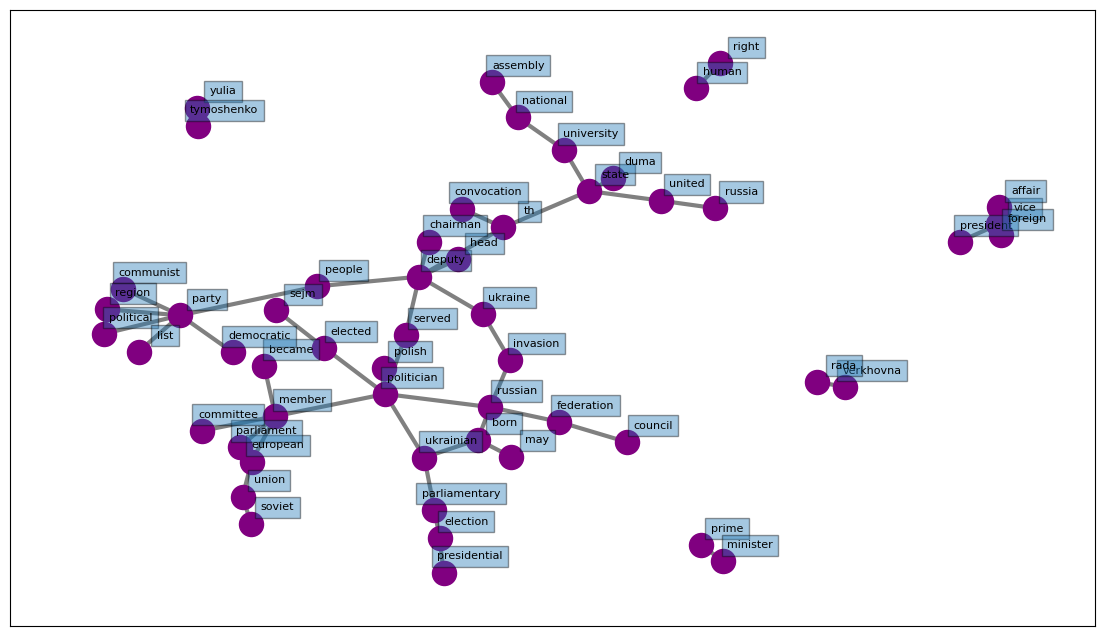

In [252]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))
    
fig, ax = plt.subplots(figsize=(14, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.05, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.4),
            horizontalalignment='center', fontsize=8)
    
plt.show()

In [261]:
list(G.adj['deputy'])

['people', 'th', 'head', 'served', 'ukraine', 'chairman']

### Trigrams

In [207]:
# Train trigram model on all tockets
trigram  = Phrases(phrase_model[all_tokens], min_count = 10)
#print(trigram)

# Create a list of all trigrams
trigram_list = []
for token in all_tokens:
    trigrams_ = [t for t in trigram[phrase_model[token]] if t.count('_')==2]
    if len(trigrams_) > 0:
        trigram_list.append(trigrams_) 
    
print('Total number of documents with trigrams:', len(trigram_list))

# create dictionary of trigrams
trigram_dic = Dictionary(trigram_list)
print('Number of unique trigrams:', len(trigram_dic.keys()))

# Top 100 tigrams by frequency in all articles
trigram_most_freq = trigram_dic.most_common(100)
print('\nTop 20 trigrams by frequency\n')

num = 1
for t, f in trigram_most_freq[:20]:
    print(str(num) + '.', t, '-', f)
    num = num + 1

Total number of documents with trigrams: 381
Number of unique trigrams: 60

Top 20 trigrams by frequency

1. verkhovna_rada_ukraine - 59
2. th_state_duma - 55
3. united_russia_party - 53
4. russian_invasion_ukraine - 47
5. relation_russo_ukrainian - 43
6. deputy_prime_minister - 40
7. sanctioned_uk_government - 40
8. russian_political_figure - 36
9. deputy_state_duma - 34
10. social_democratic_party - 33
11. september_getting_vote - 31
12. ukrainian_presidential_election - 31
13. elected_verkhovna_rada - 30
14. tara_shevchenko_national - 27
15. national_assembly_mp - 25
16. president_vladimir_putin - 24
17. inter_parliamentary_relation - 24
18. committee_foreign_affair - 23
19. petro_poroshenko_bloc - 23
20. foreign_affair_minister - 21


## LDA

In [219]:
# Train our lda model
lda_model = LdaModel(corpus, num_topics = 6, iterations = 10, 
                     id2word=dictionary, passes = 10, random_state = 100)

# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.024*"polish" + 0.016*"sejm" + 0.016*"election" + 0.015*"party" + 0.014*"elected" + 0.011*"vote" + 0.011*"poland" + 0.009*"parliamentary" + 0.008*"candidate" + 0.007*"also"
Topic: 1 
Words: 0.018*"european" + 0.012*"party" + 0.011*"parliament" + 0.010*"right" + 0.009*"also" + 0.008*"president" + 0.007*"moldova" + 0.007*"election" + 0.007*"foreign" + 0.007*"russian"
Topic: 2 
Words: 0.044*"russian" + 0.031*"state" + 0.023*"deputy" + 0.020*"russia" + 0.019*"duma" + 0.013*"th" + 0.010*"elected" + 0.010*"united" + 0.009*"party" + 0.008*"council"
Topic: 3 
Words: 0.016*"minister" + 0.013*"european" + 0.012*"party" + 0.010*"committee" + 0.010*"woman" + 0.010*"president" + 0.010*"parliament" + 0.010*"romanian" + 0.008*"served" + 0.007*"deputy"
Topic: 4 
Words: 0.043*"ukraine" + 0.033*"ukrainian" + 0.012*"deputy" + 0.011*"rada" + 0.010*"verkhovna" + 0.010*"people" + 0.010*"kyiv" + 0.010*"party" + 0.009*"election" + 0.009*"law"
Topic: 5 
Words: 0.018*"election" + 0.013*"party"

In [217]:
query = 'Leadership is the ability of an individual or a group of people to influence and guide followers or members of an organization, society or team.'
vec_bow = dictionary.doc2bow(query.lower().split())

# convert the query to LSI space
vec_lda = lda_model[vec_bow]  
# This shows how the query relates to the topics
vec_lda

[(0, 0.010418119),
 (1, 0.010418118),
 (2, 0.010418108),
 (3, 0.01041811),
 (4, 0.010418115),
 (5, 0.010418121),
 (6, 0.010418113),
 (7, 0.0104181105),
 (8, 0.46593794),
 (9, 0.010418114),
 (10, 0.38820848),
 (11, 0.010418118),
 (12, 0.0104181105),
 (13, 0.01041811),
 (14, 0.010418117),
 (15, 0.010418108)]

In [178]:
# probability of a word belonging to a topic
test_words = ['leader']
for topic, prob in lda_model.get_term_topics(test_words):
     print('Word:', test_words, ' - belongs to\nTopic: {} \nProbability: {}'.format(topic, prob))

## Optimal number of topics

https://radimrehurek.com/gensim/models/coherencemodel.html

Best coherence for umass is typically the minimum. Best coherence for c_v is typically the maximum. Umass is faster than c_v, but in my experience c_v gives better scores for optimal number of topics. This is not a hard decision rule. It depends on the use case. If you're evaluating topics for human readability you would probably want to compare a few models with low umass to see how the top keywords look with something like pyLDAvis. Vice versa for c_v. (https://groups.google.com/g/gensim/c/Ybja9B15F1E?pli=1)

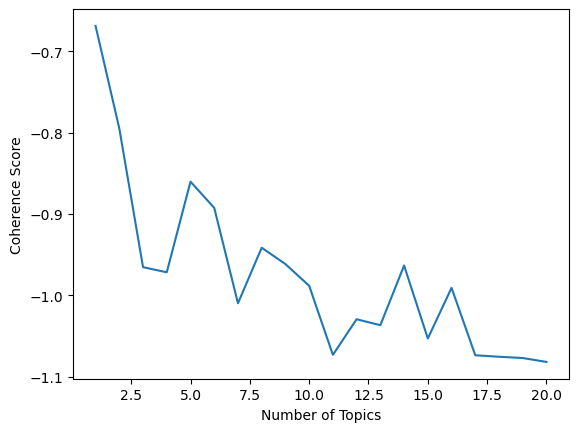

In [208]:
topics = []
score = []
for i in range(1,21,1):
    lda_model = LdaMulticore(corpus = corpus, id2word = dictionary, 
                             iterations = 10, num_topics = i, 
                             workers = 4, passes = 10, 
                             random_state = 100)
    cm = CoherenceModel(model = lda_model, corpus = corpus, dictionary = dictionary, 
                        coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [115]:
cm.get_coherence_per_topic()

[-1.121408720505659,
 -1.620948737495374,
 -1.016521056526982,
 -0.9427682281559027,
 -0.7965999335753292,
 -0.8983108169177831,
 -0.9772901750221601,
 -0.9842819942578864,
 -1.0971731865615264,
 -0.8397444395327783,
 -1.225205644950186,
 -2.2727980605449463,
 -0.5761655517629698,
 -1.198334748579557,
 -1.9497283730234263,
 -1.2170527814992054,
 -0.732242998770254,
 -0.7673325409502417,
 -0.7954118441281258,
 -0.751193564483038]

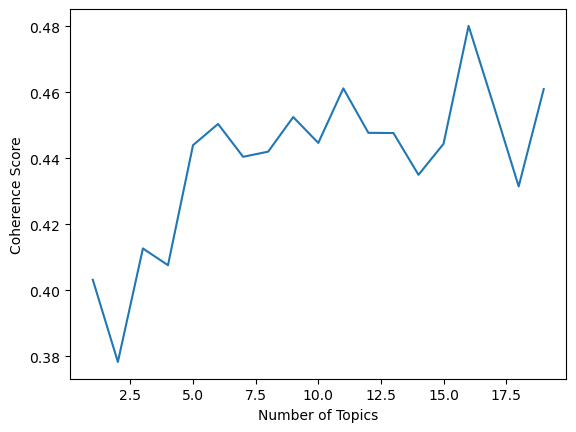

In [214]:
# Calculating the coherence score using C_v
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, 
                             iterations=10, num_topics=i, 
                             workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = all_tokens, corpus=corpus, 
                        dictionary=dictionary, 
                        coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
    
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

## Visualisation

In [116]:
import pyLDAvis
import pyLDAvis.gensim

In [220]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.033108  0.025249       1        1  19.506915
1      0.063437  0.030572       2        1  19.242953
2     -0.099886  0.007987       3        1  18.240365
3      0.021476  0.033427       4        1  15.853202
5      0.036688  0.003327       5        1  14.945560
0      0.011392 -0.100563       6        1  12.211005, topic_info=           Term         Freq        Total Category  logprob  loglift
969     russian  1363.000000  1363.000000  Default  30.0000  30.0000
1079    ukraine  1386.000000  1386.000000  Default  29.0000  29.0000
679      polish   357.000000   357.000000  Default  28.0000  28.0000
747   ukrainian  1093.000000  1093.000000  Default  27.0000  27.0000
1310       duma   441.000000   441.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
747   ukrainian    82.949813  1093.361019   Topic6  -5.1245  -0.4759
137      became    73.280092   560.602289   Topic6  -5.2484   0.0681
78     national    72.515217   711.137492   Topic6  -5.2589  -0.1802
75     minister    69.669938   815.951855   Topic6  -5.2990  -0.3578
89    president    69.165116   747.800467   Topic6  -5.3062  -0.2778

[397 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1110      2  0.787888  accession
1110      4  0.164143  accession
184       1  0.112439     affair
184       2  0.347237     affair
184       3  0.089290     affair
...     ...       ...        ...
1319      2  0.091877      yulia
1319      3  0.058467      yulia
1319      4  0.016705      yulia
1319      5  0.492793      yulia
1319      6  0.108581      yulia

[1620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 4, 6, 1])

## Test for different types of stemming

In [79]:
# pip install pattern
# from gensim.utils import lemmatize

In [94]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer

In [101]:
# Initialize stemmers
stemmer = SnowballStemmer("english")
ps = PorterStemmer()

# Compare results of Snowball and Porter stemmers
print("{0:20}{1:20}{2:20}".format("--Word--","--Stem SB--", "--Stem Porter--"))
for word in doc_out[:30]:
    print("{0:20}{1:20}{2:20}".format(word, stemmer.stem(word) , ps.stem(word)))

--Word--            --Stem SB--         --Stem Porter--     
sylvia              sylvia              sylvia              
acevedo             acevedo             acevedo             
born                born                born                
american            american            american            
engineer            engin               engin               
businesswoman       businesswoman       businesswoman       
chief               chief               chief               
executive           execut              execut              
officer             offic               offic               
ceo                 ceo                 ceo                 
girl                girl                girl                
scout               scout               scout               
usa                 usa                 usa                 
system              system              system              
engineer            engin               engin               
education           educ